In [11]:
## For cross-platform, pathlib is apparently nice. Read about it here: (https://docs.python.org/3/library/pathlib.html)
from pathlib import Path

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
## We need to link to the datasets. These are too large to put on github, perhaps we should set up a dvc?
# Update paths as needed.
BACI_folder_path_init = r"C:\Users\mhm25\Desktop\ITU\6thSemester\bachelorproj\data\BACI_sets"
BACI_folder_path = Path(BACI_folder_path_init).as_posix()

ACLED_folder_path_init = r"C:\Users\mhm25\Desktop\ITU\6thSemester\bachelorproj\data\ACLED_sets"
ACLED_folder_path = Path(ACLED_folder_path_init).as_posix()

Gravity_folder_path_init = r"C:\Users\mhm25\Desktop\ITU\6thSemester\bachelorproj\data\Gravity_sets"
Gravity_folder_path = Path(Gravity_folder_path_init).as_posix()

C:\Users\mhm25\AppData\Local\Temp\ipykernel_22452\1823189088.py:35: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


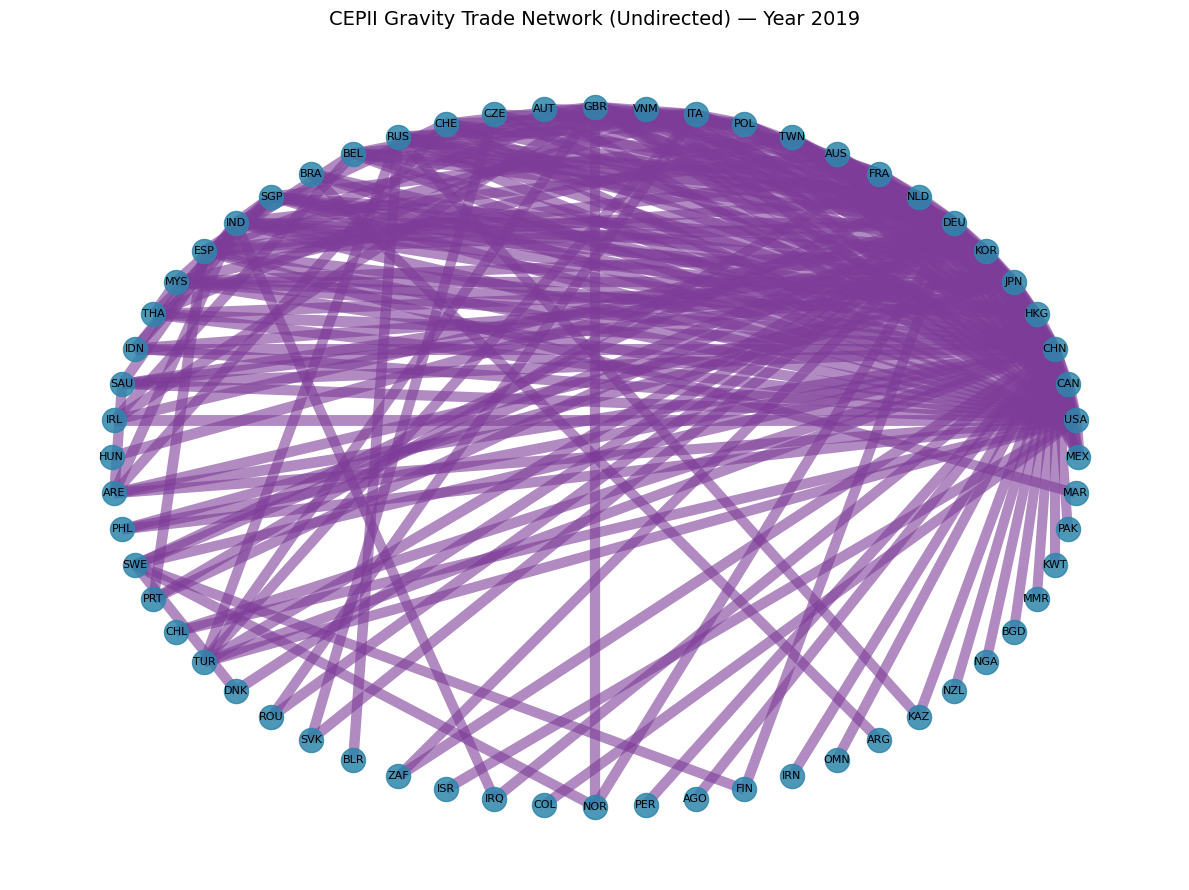

In [14]:
###
# Gravity DATASET - Initial network
###


# ---------- CONFIG ----------
DATA_PATH = f"{Gravity_folder_path}/Gravity_V202211.csv"   # or "gravity.parquet"
YEAR = 2019                             # choose the year to visualize
DIRECTED = False                        # True for directed (exports), False for undirected (bilateral total)
TOP_EDGES = 200                         # None for all edges; or limit to top-N edges by weight
MIN_TRADE = None                        # e.g., 1_000_000 to threshold small edges
EDGE_WIDTH_SCALE = 0.0005               # adjust until widths look good for your units
MIN_EDGE_WIDTH = 0.5
NODE_SIZE = 300
LABELS = "iso"                          # "iso" or "none"

# Column names from your header dump
ORIGIN_COL = "iso3_o"
DEST_COL = "iso3_d"
YEAR_COL = "year"

# Trade source preference:
# 1) Try BACI bilateral trade, otherwise
# 2) Use sum of direction-specific sources if available (COMTRADE or IMF)
PREFERRED_BILATERAL_COLS = ["tradeflow_baci", "manuf_tradeflow_baci"]
DIRECTED_SOURCE_PAIRS = [
    ("tradeflow_comtrade_o", "tradeflow_comtrade_d"),
    ("tradeflow_imf_o", "tradeflow_imf_d"),
]

# ---------- LOAD ----------
if DATA_PATH.lower().endswith(".parquet"):
    df = pd.read_parquet(DATA_PATH)
else:
    df = pd.read_csv(DATA_PATH)

# ---------- FILTER YEAR ----------
if YEAR_COL in df.columns:
    df = df[df[YEAR_COL] == YEAR]

# ---------- BUILD TRADE VALUE ----------
# Strategy:
# - If a bilateral column (BACI) exists and has values, use that.
# - Else, try to construct bilateral totals by summing origin->dest and dest->origin
#   from a directed pair (COMTRADE or IMF).

bilateral_col = None
for col in PREFERRED_BILATERAL_COLS:
    if col in df.columns and df[col].notna().any():
        bilateral_col = col
        break

# Clean missing values in candidate columns
candidate_cols = set(PREFERRED_BILATERAL_COLS)
for a, b in DIRECTED_SOURCE_PAIRS:
    candidate_cols.update([a, b])

for col in candidate_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

if bilateral_col:
    # Use the chosen bilateral column directly
    df["trade_val"] = df[bilateral_col]
else:
    # Fall back: construct bilateral totals by pairing rows
    # We'll build a directed aggregate first, then combine symmetrically if undirected.
    # Create a unified directed_value that prefers COMTRADE then IMF (o->d)
    df["directed_value"] = None
    for o_col, d_col in DIRECTED_SOURCE_PAIRS:
        if (o_col in df.columns) and df[o_col].notna().any():
            df["directed_value"] = df[o_col].where(df[o_col].notna(), df["directed_value"])
            break

    # If we want UNDIRECTED and we have both directions available, we need to sum A->B and B->A.
    if not DIRECTED:
        # Build symmetric pair key
        df["_pair"] = df[[ORIGIN_COL, DEST_COL]].apply(lambda x: tuple(sorted(x)), axis=1)
        # Aggregate across both directions using available sources:
        # Start with zero, sum across all available trade columns (BACI/manuf + COMTRADE + IMF)
        sum_cols = [c for c in PREFERRED_BILATERAL_COLS if c in df.columns]
        for o_col, d_col in DIRECTED_SOURCE_PAIRS:
            if o_col in df.columns:
                sum_cols.append(o_col)
            if d_col in df.columns:
                sum_cols.append(d_col)
        if sum_cols:
            df["trade_val"] = df[sum_cols].sum(axis=1, skipna=True)
        else:
            raise ValueError("No recognizable trade flow columns found to compute trade totals.")
    else:
        # Directed graph: use origin->dest flow (prefer COMTRADE, then IMF; else try BACI)
        if df["directed_value"].isna().all():
            # If we didn't find a directed source, as a last resort use BACI if present
            if "tradeflow_baci" in df.columns:
                df["directed_value"] = df["tradeflow_baci"]
            else:
                raise ValueError("No directed trade source available (COMTRADE or IMF or BACI).")
        df["trade_val"] = df["directed_value"]

# Drop NA and non-positive (if you want only positive flows)
df = df.dropna(subset=[ORIGIN_COL, DEST_COL, "trade_val"])
df = df[df["trade_val"] > 0]

# ---------- AGGREGATE ----------
if DIRECTED:
    agg = (df.groupby([ORIGIN_COL, DEST_COL], as_index=False)["trade_val"]
             .sum()
             .rename(columns={"trade_val": "weight"}))
else:
    # Aggregate symmetric pairs (A-B equals B-A)
    df["_u"] = df[[ORIGIN_COL, DEST_COL]].apply(lambda x: tuple(sorted(x)), axis=1)
    agg = (df.groupby("_u", as_index=False)["trade_val"]
             .sum()
             .rename(columns={"trade_val": "weight"}))
    agg[[ORIGIN_COL, DEST_COL]] = pd.DataFrame(agg["_u"].tolist(), index=agg.index)
    agg = agg.drop(columns=["_u"])

# ---------- THRESHOLD / TOP-N ----------
if MIN_TRADE is not None:
    agg = agg[agg["weight"] >= MIN_TRADE]
if TOP_EDGES is not None:
    agg = agg.sort_values("weight", ascending=False).head(TOP_EDGES)

# ---------- BUILD GRAPH ----------
G = nx.DiGraph() if DIRECTED else nx.Graph()
for _, row in agg.iterrows():
    u, v, w = row[ORIGIN_COL], row[DEST_COL], row["weight"]
    G.add_edge(u, v, weight=w)

# ---------- LAYOUT ----------
#pos = nx.spring_layout(G, seed=42)
pos = nx.circular_layout(G)

# ---------- EDGE WIDTHS ----------
weights = [d["weight"] for (_, _, d) in G.edges(data=True)]
edge_widths = [max(MIN_EDGE_WIDTH, w * EDGE_WIDTH_SCALE) for w in weights]

# Trying a separate edge_width
weights = np.array([d["weight"] for (_, _, d) in G.edges(data=True)], dtype=float)
if len(weights) == 0:
    print("No edges to draw—check filters like YEAR/TOP_EDGES/MIN_TRADE.")
else:
    # Choose ONE of these scalings:

    # A) Log scaling (great when values span orders of magnitude)
    edge_widths = np.log10(weights + 1)  # +1 avoids log(0)


# ---------- DRAW ----------
plt.figure(figsize=(12, 9))
nx.draw_networkx_nodes(G, pos, node_size=NODE_SIZE, node_color="#2E86AB", alpha=0.85)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color="#7D3C98", alpha=0.6)
if LABELS == "iso":
    nx.draw_networkx_labels(G, pos, font_size=8)

plt.title(f"CEPII Gravity Trade Network ({'Directed' if DIRECTED else 'Undirected'}) — Year {YEAR}", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

# ---------- OPTIONAL: SAVE ----------
# plt.savefig("gravity_trade_network.png", dpi=300, bbox_inches="tight")




In [10]:
df

,year,country_id_o,country_id_d,iso3_o,iso3_d,iso3num_o,iso3num_d,country_exists_o,country_exists_d,gmt_offset_2020_o,...,entry_tp_o,entry_tp_d,tradeflow_comtrade_o,tradeflow_comtrade_d,tradeflow_baci,manuf_tradeflow_baci,tradeflow_imf_o,tradeflow_imf_d,trade_val,_u
145,2019,ABW,AFG,ABW,AFG,533.0,4.0,1,1,-4.0,...,NaN,12.5,NaN,483.922,440.339,440.339,NaN,NaN,440.339,"(ABW, AFG)"
219,2019,ABW,AGO,ABW,AGO,533.0,24.0,1,1,-4.0,...,NaN,44.0,NaN,10.039,10.039,10.039,NaN,10.044,10.039,"(ABW, AGO)"
663,2019,ABW,ARE,ABW,ARE,533.0,784.0,1,1,-4.0,...,NaN,5.8,NaN,889.701,863.826,863.826,16.493,889.712,863.826,"(ABW, ARE)"
737,2019,ABW,ARG,ABW,ARG,533.0,32.0,1,1,-4.0,...,NaN,23.5,NaN,0.003,0.003,0.003,0.344,NaN,0.003,"(ABW, ARG)"
959,2019,ABW,ATG,ABW,ATG,533.0,28.0,1,1,-4.0,...,NaN,28.0,NaN,NaN,2.039,2.039,0.838,2.045,2.039,"(ABW, ATG)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4697961,2019,ZWE,USA,ZWE,USA,716.0,840.0,1,1,2.0,...,36.0,10.2,2372.274,48698.190,43144.884,36022.781,2372.280,46997.887,43144.884,"(USA, ZWE)"
4698035,2019,ZWE,UZB,ZWE,UZB,716.0,860.0,1,1,2.0,...,36.0,6.0,NaN,1621.539,1621.539,0.000,NaN,1621.540,1621.539,"(UZB, ZWE)"
4698923,2019,ZWE,YEM.2,ZWE,YEM,716.0,887.0,1,1,2.0,...,36.0,46.5,NaN,12.140,12.140,12.140,NaN,12.142,12.140,"(YEM, ZWE)"
4699145,2019,ZWE,ZAF,ZWE,ZAF,716.0,710.0,1,1,2.0,...,36.0,47.0,1692830.182,175992.585,940157.344,656502.563,2104516.000,184352.312,940157.344,"(ZAF, ZWE)"
